# Housing Values in Suburbs of Boston

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive [link](http://lib.stat.cmu.edu/datasets/boston). Also available in scikit-learn built in datasets.

## Objective: 
* Train regression models for medv (Median value of owner-occupied homes in `$1000`'s) using:
    * OLR
    * Regularized regression:
        * Ridge
        * LASSO
        * Elastic net
* Examine prediction metrics such as R squared and RMSE
* Perform hyperparameter tuning with the elastic net regularization, assess model performance by splittig off hold-out data to test as unseen data 

### Data description

The Boston data frame has 506 rows and 14 columns.
This data frame contains the following columns:

* crim: per capita crime rate by town.
* zn: proportion of residential land zoned for lots over 25,000 sq.ft.
* indus: proportion of non-retail business acres per town.
* chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
* nox: nitrogen oxides concentration (parts per 10 million).
* rm: average number of rooms per dwelling.
* age: proportion of owner-occupied units built prior to 1940.
* dis: weighted mean of distances to five Boston employment centres.
* rad: index of accessibility to radial highways.
* tax: full-value property-tax rate per \$10,000.
* ptratio: pupil-teacher ratio by town.
* black: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
* lstat: lower status of the population (percent).
* medv: median value of owner-occupied homes in \$1000s.

### Note
Variable 14 seems to be censored at 50.00, corresponding to a median price of `$50,000`.

Censoring is suggested by the fact that the highest median price of exactly `$50,000`
is reported in 16 cases, while 15 cases have prices between `$40,000` and `$50,000`, with prices rounded to the nearest hundred. Harrison and Rubinfeld do not mention any censoring.


### Sources

Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

In [44]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import linear_model

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Set plotting style
plt.style.use('ggplot')

In [2]:
boston = pd.read_csv('train.csv')

In [3]:
# Examine data
boston.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [4]:
# Drop ID column, not needed
boston.drop('ID', axis=1, inplace=True)

In [5]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [6]:
# Creating feature and target arrays
X = boston.drop('medv', axis=1).values
y = boston['medv'].values

As a first task, let's try to predict the price from a single feature: the average number of rooms

In [7]:
X_rooms = X[:, 5]
type(X_rooms), type(y)

(numpy.ndarray, numpy.ndarray)

In [8]:
# Turn into NumPy arrays of desired shape
# Keep first dimension, but add another dimension of size 1 to X
y = y.reshape(-1, 1)
X_rooms = X_rooms.reshape(-1, 1)

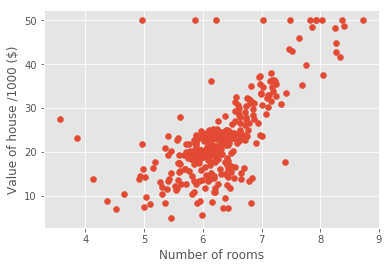

In [9]:
# Plotting house value vs. number of rooms
plt.scatter(X_rooms, y)
plt.ylabel('Value of house /1000 ($)')
plt.xlabel('Number of rooms')
plt.show()

In [10]:
# Instantiate Linear Regression
reg = linear_model.LinearRegression()

In [11]:
reg.fit(X_rooms, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

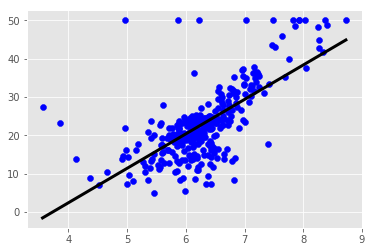

In [12]:
# Fitting a regression model
# Set up the prediction space to range from the min to the max of number of rooms
prediction_space = np.linspace(min(X_rooms),
                               max(X_rooms)).reshape(-1, 1)
plt.scatter(X_rooms, y, color='blue')
plt.plot(prediction_space, reg.predict(prediction_space),
         color='black', linewidth=3)
plt.show()

# Root Mean Squared Error (RMSE) vs. Coefficient of Determination (R Squared)

* Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. 

* RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. 

* As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. 

* RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction. 

[link](https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/)

$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}} $

In [13]:
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(X_rooms, reg.predict(X_rooms)))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 17.431768231854107


We generally don't want to use linear regression out of the box like this; We will most likely want to use regularization instead (places constraints on model coefficients).

To play with more regression tools, we load the toy dataset from scikit-learn.

In [14]:
skl_boston = datasets.load_boston()

In [15]:
# Create feature and target arrays
skl_X = skl_boston.data
skl_y = skl_boston.target

In [16]:
skl_reg = linear_model.LinearRegression()

Let's first look at the K-fold cross validation results.
The default scoring method used is ${R}^{2}$.

In [17]:
cv5_results = cross_val_score(skl_reg, skl_X, skl_y, cv=5)
cv5_mean = np.mean(cv5_results)
cv10_results = cross_val_score(skl_reg, skl_X, skl_y, cv=10)
cv10_mean = np.mean(cv10_results)

In [18]:
print("5 fold:",cv5_results, "\n"
      "5 fold mean:", cv5_mean, "\n")
print("10 fold:",cv10_results, "\n"
      "10 fold mean:", cv10_mean, "\n")

5 fold: [ 0.63919994  0.71386698  0.58702344  0.07923081 -0.25294154] 
5 fold mean: 0.3532759243958799 

10 fold: [ 0.73376082  0.4730725  -1.00631454  0.64113984  0.54766046  0.73640292
  0.37828386 -0.12922703 -0.76843243  0.4189435 ] 
10 fold mean: 0.2025289900605652 



In [19]:
%timeit cross_val_score(skl_reg, skl_X, skl_y, cv=10)

11.5 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Now let's use a regularized regression
### Ridge

In [20]:
skl_X_train, skl_X_test, skl_y_train, skl_y_test = train_test_split(skl_X, skl_y, 
                                                                    test_size = 0.3, random_state=42)

In [21]:
ridge = linear_model.Ridge(alpha=0.1, normalize=True)

In [22]:
ridge.fit(skl_X_train, skl_y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [23]:
ridge_pred = ridge.predict(skl_X_test)

In [24]:
ridge.score(skl_X_test, skl_y_test)

0.6996938275127313

Compare a range of different alphas to pick the best one for fine tuning model.

In [34]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [31]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

In [32]:
linear_model.Ridge(alpha=0.1, normalize=True)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

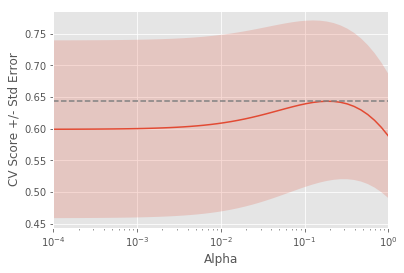

In [33]:
# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, skl_X_test, skl_y_test, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

### Lasso

In [35]:
lasso = linear_model.Lasso(alpha=0.1, normalize=True)

In [36]:
lasso.fit(skl_X_train, skl_y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [37]:
lasso_pred = lasso.predict(skl_X_test)

In [38]:
lasso.score(skl_X_test, skl_y_test)

0.5950229535328551

### LASSO Feature Selection

Lasso shrinks the coefficients of less important features to exactly zero. Those not shrunk are considered **selected**.

In [39]:
skl_boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [40]:
names = skl_boston['feature_names']

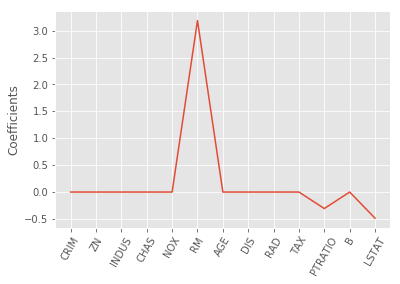

In [41]:
lasso_coef = lasso.coef_
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

We see that the most powerful predictor for housing price if number of rooms.

* Lasso used the L1 penalty to regularize, while ridge used the L2 penalty. 
* There is another type of regularized regression known as the elastic net. In elastic net regularization, the penalty term is a linear combination of the L1 and L2 penalties: 
$a∗L1+b∗L2$
* In scikit-learn, this term is represented by the 'l1_ratio' parameter: An 'l1_ratio' of 1 corresponds to an L1 penalty, and anything lower is a combination of L1 and L2.

In [47]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(skl_X, skl_y, test_size = 0.4, random_state=42)

In [48]:
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = linear_model.ElasticNet()

In [49]:
# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'l1_ratio': array([0.     , 0.03448, 0.06897, 0.10345, 0.13793, 0.17241, 0.2069 ,
       0.24138, 0.27586, 0.31034, 0.34483, 0.37931, 0.41379, 0.44828,
       0.48276, 0.51724, 0.55172, 0.58621, 0.62069, 0.65517, 0.68966,
       0.72414, 0.75862, 0.7931 , 0.82759, 0.86207, 0.89655, 0.93103,
       0.96552, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.663764830726389
Tuned ElasticNet MSE: 25.534903714957323
